# Lego Image Recognition - CNN
The goal of this notebook was to see how effective CNN's could be at image recognition, specifically with Lego's.

# For evaluation, 
results should be reported for all models using at least the four basic 
metrics: precision, recall, accuracy, and F1 score

##  Initial Imports

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")
import PIL
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow.python as tf
from tensorflow import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import layers, models
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Data Ingestion and Initial Transformation

In [5]:
# Opens the image
tech_lever = Image.open(r'LEGO\6632 Technic Lever 3M\201706171606-0400.png')

print("Format: " + str(tech_lever.format))
print("Size: " + str(tech_lever.size))

tech_lever.show() # Opens the image in different window

Format: PNG
Size: (200, 200)


In [6]:
block_types = os.listdir(r'LEGO') # Display our classes
block_types

['11214 Bush 3M friction with Cross axle',
 '18651 Cross Axle 2M with Snap friction',
 '2357 Brick corner 1x2x2',
 '3003 Brick 2x2',
 '3004 Brick 1x2',
 '3005 Brick 1x1',
 '3022 Plate 2x2',
 '3023 Plate 1x2',
 '3024 Plate 1x1',
 '3040 Roof Tile 1x2x45deg',
 '3069 Flat Tile 1x2',
 '32123 half Bush',
 '3673 Peg 2M',
 '3713 Bush for Cross Axle',
 '3794 Plate 1X2 with 1 Knob',
 '6632 Technic Lever 3M']

Format: float32
Size: (200, 200, 4)


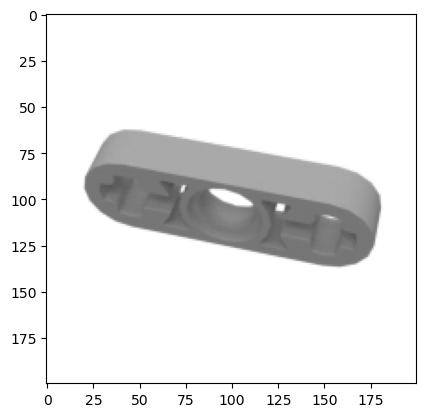

In [7]:
# Read the image in as an array for matplotlib
tech_lever = image.imread(r'LEGO\6632 Technic Lever 3M\201706171606-0400.png')

print("Format: " + str(tech_lever.dtype))
print("Size: " + str(tech_lever.shape))

# Plot the image
plt.imshow(tech_lever);

In [9]:
# Code to load in the images

# The list of images
image_list = os.listdir(r'LEGO')
images = []

# Loop through each different block type
for name in image_list:
    selected_images = os.listdir(r'LEGO'+"/"+name+"/")
    
    # Loop through each image in the selected block type
    for imgs in selected_images:                
        image = load_img(r'LEGO'+"/"+name+"/" + imgs)
        image = img_to_array(image)
        
        # Save the image and it's name
        images.append([name,image])

In [10]:
# Save the data to a dataframe
blocks_df = pd.DataFrame(images,columns = ['Block Type','Array'])
blocks_df

,Block Type,Array
0,11214 Bush 3M friction with Cross axle,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,11214 Bush 3M friction with Cross axle,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,11214 Bush 3M friction with Cross axle,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,11214 Bush 3M friction with Cross axle,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,11214 Bush 3M friction with Cross axle,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...
6374,6632 Technic Lever 3M,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
6375,6632 Technic Lever 3M,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
6376,6632 Technic Lever 3M,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
6377,6632 Technic Lever 3M,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [11]:
# Transform the arrays into images of the correct dimensions
def fix_dimensions(df):
    images = []
    for arr in np.array(df):
        images += [arr[0]] # Correct the shape
    images = np.array(images)

    print(images.shape) # Check the shape
    return images
    
images = fix_dimensions(blocks_df.drop(columns=['Block Type']))

(6379, 200, 200, 3)


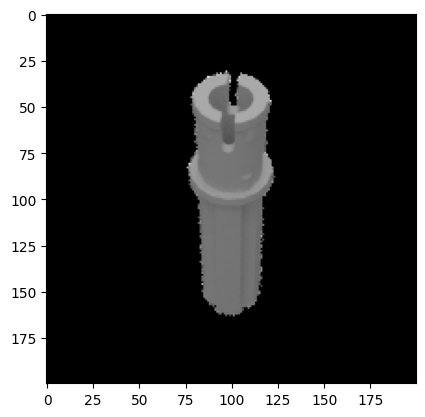

In [8]:
# Displaying the different images

plt.imshow(images[600].astype('int32'))

# Test - Train Split

In [9]:
# Train-Test Split
X = blocks_df.drop(columns=["Block Type"])
y = blocks_df.drop(columns=["Array"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=1)

# Fixing the dimensions for the images- best for feeding to CNN
X_train = fix_dimensions(X_train)/255.0
X_test = fix_dimensions(X_test)/255.0

(1594, 200, 200, 3)
(4785, 200, 200, 3)


# Create and Train CNN

In [10]:
# Encoding the classes for the model
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Putting it to categorical
unique_classes = len(np.unique(blocks_df['Block Type']))
y_train = to_categorical(y_train, unique_classes)
y_test = to_categorical(y_test, unique_classes)

In [11]:
# Building the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(400, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(unique_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 400)                 │      13,107,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           6,416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,682,592 (56.01 MB)

 Trainable params: 14,682,592 (56.01 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Training the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.1794 - f1_score: 0.1668 - loss: 2.4541 - precision: 0.4646 - recall: 0.0434 - val_accuracy: 0.5699 - val_f1_score: 0.5332 - val_loss: 1.2543 - val_precision: 0.8247 - val_recall: 0.2842
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.5632 - f1_score: 0.5522 - loss: 1.2530 - precision: 0.7175 - recall: 0.4077 - val_accuracy: 0.6763 - val_f1_score: 0.6584 - val_loss: 0.9058 - val_precision: 0.7449 - val_recall: 0.6217
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7161 - f1_score: 0.7038 - loss: 0.7860 - precision: 0.7936 - recall: 0.6319 - val_accuracy: 0.7444 - val_f1_score: 0.7409 - val_loss: 0.7128 - val_precision: 0.8221 - val_recall: 0.6606
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7873 - f1_score: 0.7824 - loss: 0.6137 - precision: 0.8476 - recall: 0.7148 - val_accuracy: 0.7990 - val_f1_score: 0.7959 - val_loss: 0.5899 - val_precision: 0.8484 - val_recall: 0.761

# Accuracy & Output Results


150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 290ms/step - accuracy: 0.8362 - f1_score: 0.8331 - loss: 0.7102 - precision: 0.8451 - recall: 0.8314
Testing Loss 0.7065703868865967
Testing Accuracy: 0.8386625051498413


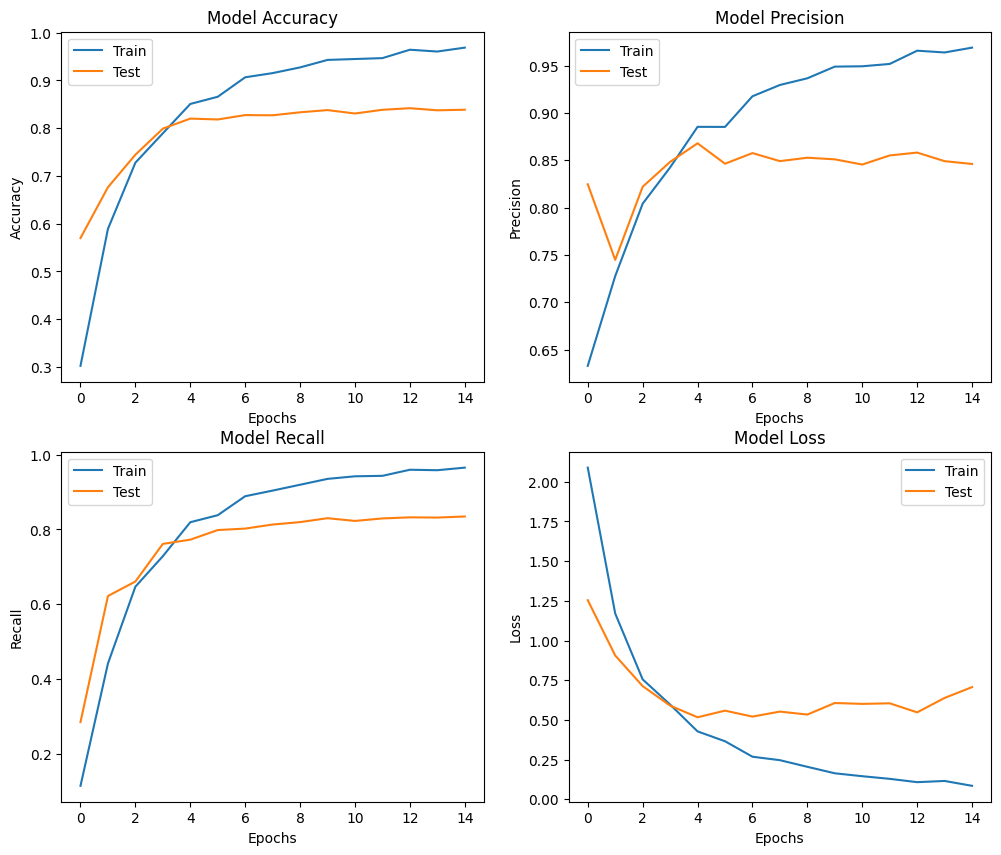

In [13]:
# Evaluation Statistics
test_lss, test_acc, test_prc, test_rec, test_f1 = model.evaluate(X_test, y_test)

print("Testing Loss " + str(test_lss))
print("Testing Accuracy: " + str(test_acc))

# Plotting
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['precision'], label="Train")
plt.plot(history.history['val_precision'], label="Test")
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend();

plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label="Train")
plt.plot(history.history['val_recall'], label="Test")
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend();

plt.subplot(2, 2, 4)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Test")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();
plt.savefig("model_test_eval.png", format = "png", dpi=400)

In [14]:
# Print Evaluation 
print("Test Accuracy: " + str(test_acc))
print("Test Precision: "+ str(float(np.mean(test_prc))))
print("Test Recall: " + str(test_rec))
print("Test F1 Score: " + str(test_f1))

Test Accuracy: 0.8386625051498413
Test Precision: 0.8390123248100281
Test Recall: 0.8461864590644836
Test F1 Score: 0.8346917629241943


# Improvements Made

Below are a list of tunings made to improve our model off of the base CNN:
* Added layers (started with 2 layers, tried up to 6)
* Increased/fine tuned the number of epochs (started with 5 epochs, tried up to 35)
* Used a dropout layer to randomly drop extra neurons